In [29]:
import cv2
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

current_directory = os.getcwd()
while not current_directory.endswith('pneumonia_detection'):
    current_directory = os.path.dirname(current_directory)
root_directory = current_directory
os.chdir(root_directory)
sys.path.insert(0, root_directory)

from src.utils.utils import *

In [30]:
DATA_DIR = os.path.join(root_directory, 'data_processed')

## Check number of files in train, test, and validation sets

### Check number of files in train sets

In [31]:
normal_lungs = [[], [] , []]
pneumonia_lungs = [[], [], []]

In [32]:
data_paths = {
    'train': {
        'NORMAL': os.path.join(DATA_DIR, 'train', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'train', 'PNEUMONIA')
    },
    'val': {
        'NORMAL': os.path.join(DATA_DIR, 'val', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'val', 'PNEUMONIA')
    },
    'test': {
        'NORMAL': os.path.join(DATA_DIR, 'test', 'NORMAL'),
        'PNEUMONIA': os.path.join(DATA_DIR, 'test', 'PNEUMONIA')
    }
}

In [33]:
file_names = {
    'train': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'val': {
        'NORMAL': [],
        'PNEUMONIA': []
    },
    'test': {
        'NORMAL': [],
        'PNEUMONIA': []
    }
}

In [34]:
file_names['train']['NORMAL'] = list_folder(data_paths['train']['NORMAL'])
file_names['train']['PNEUMONIA'] = list_folder(data_paths['train']['PNEUMONIA'])
len(file_names['train']['NORMAL']) , len(file_names['train']['PNEUMONIA'])

(1341, 3875)

### Check number of files in val sets

In [35]:
file_names['val']['NORMAL'] = list_folder(data_paths['val']['NORMAL'])
file_names['val']['PNEUMONIA'] = list_folder(data_paths['val']['PNEUMONIA'])
len(file_names['val']['NORMAL']) , len(file_names['val']['PNEUMONIA'])

(8, 8)

### Check number of files in test sets

In [36]:
file_names['test']['NORMAL'] = list_folder(data_paths['test']['NORMAL'])
file_names['test']['PNEUMONIA'] = list_folder(data_paths['test']['PNEUMONIA'])
len(file_names['test']['NORMAL']) , len(file_names['test']['PNEUMONIA'])

(234, 390)

### Dataset Distribution Summary
| Split | NORMAL | PNEUMONIA | Total |
|-------|--------|-----------|-------|
| Train | 1,341  | 3,875     | 5,216 |
| Val   | 8      | 8         | 16    |
| Test  | 234    | 390       | 624   |

**Note:** 

- The dataset is imbalanced with ~3x more PNEUMONIA samples than NORMAL in the training set.
- There is too little data in validation set.

## Data Augmentation for NORMAL Training Samples
To address class imbalance, we create 2 augmented versions of each NORMAL training sample:
1. **Horizontal Flip** - Mirror the image horizontally
2. **Random Translation** - Shift the image randomly within ±10% of image dimensions

This will increase NORMAL training samples from 1,341 to 4,023 (1,341 original + 2,682 augmented), closer to the 3,875 PNEUMONIA samples.

In [37]:
import random

def horizontal_flip(image):
    """Flip image horizontally"""
    return cv2.flip(image, 1)

def random_translation(image, max_shift_ratio=0.1):
    """Randomly translate image within ±max_shift_ratio of image dimensions"""
    h, w = image.shape[:2]
    max_shift_x = int(w * max_shift_ratio)
    max_shift_y = int(h * max_shift_ratio)
    
    tx = random.randint(-max_shift_x, max_shift_x)
    ty = random.randint(-max_shift_y, max_shift_y)
    
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(image, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return translated

In [38]:
train_normal_path = os.path.join(DATA_DIR, 'train', 'NORMAL')
normal_files = list_folder(train_normal_path)

delete_aug_files = True
if delete_aug_files:    
    for file_name in normal_files:
        if '_flip' in file_name or '_trans' in file_name:
            file_path = os.path.join(train_normal_path, file_name)
            os.remove(file_path)
            
normal_files = list_folder(train_normal_path)

In [39]:
## AUGMENT NORMAL TRAINING SAMPLES FROM PREPROCESSED DATA
augmented_count = 0
images_to_show = []

for file_name in normal_files:
    file_path = os.path.join(train_normal_path, file_name)
    
    # Read preprocessed image
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: Unable to read image file at {file_path}")
        continue
    
    base_name = os.path.splitext(file_name)[0]
    ext = os.path.splitext(file_name)[1]
    
    # 1. Horizontal flip
    flipped = horizontal_flip(image)
    cv2.imwrite(os.path.join(train_normal_path, f"{base_name}_flip{ext}"), flipped)
    
    # 2. Random translation
    translated = random_translation(image)
    cv2.imwrite(os.path.join(train_normal_path, f"{base_name}_trans{ext}"), translated)
    
    if augmented_count < 6:
        images_to_show.extend([image, flipped, translated])
    
    augmented_count += 2

print(f"Augmentation complete!")
print(f"Original NORMAL training samples: {len(normal_files)}")
print(f"Augmented samples created: {augmented_count}")
print(f"Total NORMAL training samples: {len(normal_files) + augmented_count}")

Augmentation complete!
Original NORMAL training samples: 1341
Augmented samples created: 2682
Total NORMAL training samples: 4023


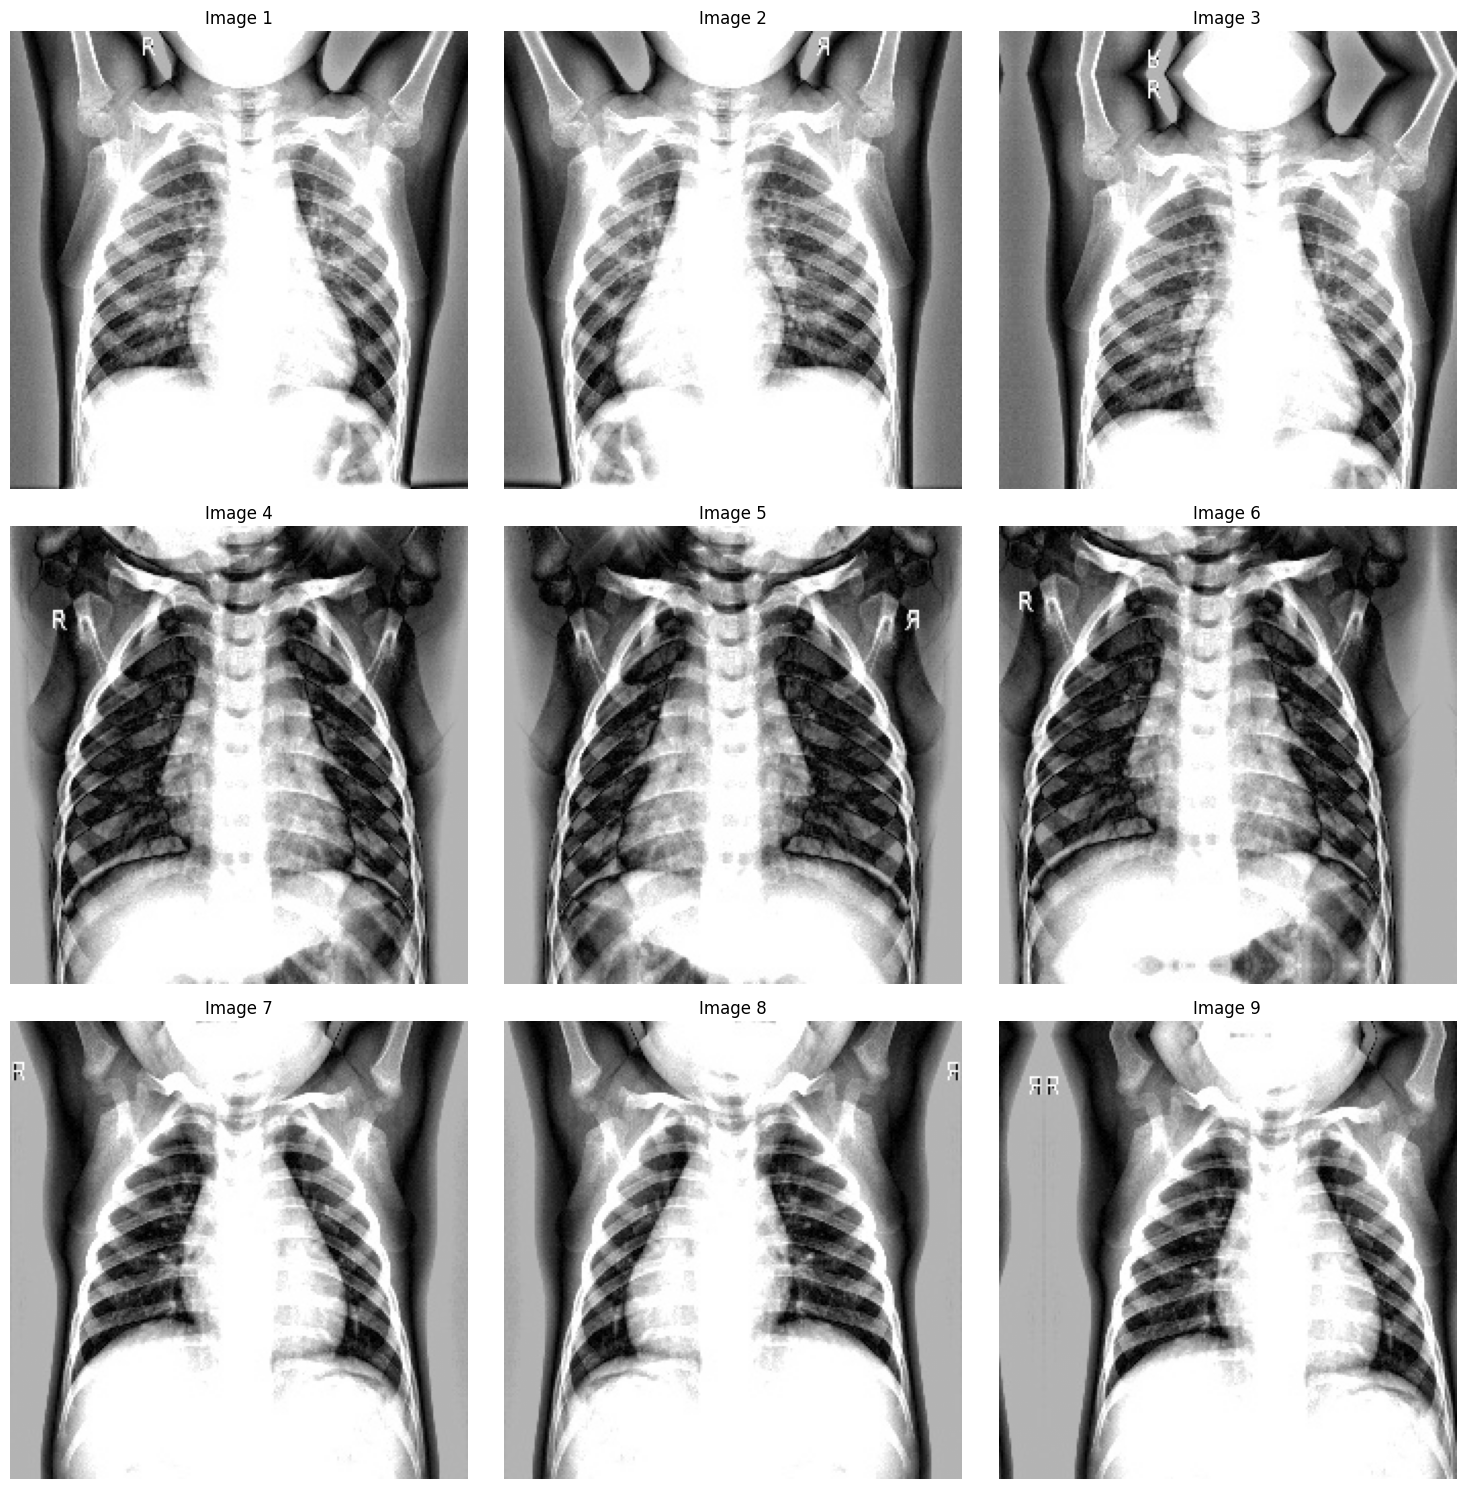

In [40]:
show_images_in_3x3_grid(images_to_show)

## Take 10% of TRAIN set -> VAL set

In [41]:
# Get current train files
train_normal_files = list_folder(data_paths['train']['NORMAL'])
train_pneumonia_files = list_folder(data_paths['train']['PNEUMONIA'])

print(f"Current TRAIN - NORMAL: {len(train_normal_files)}, PNEUMONIA: {len(train_pneumonia_files)}")
print(f"Current VAL - NORMAL: {len(list_folder(data_paths['val']['NORMAL']))}, PNEUMONIA: {len(list_folder(data_paths['val']['PNEUMONIA']))}")

Current TRAIN - NORMAL: 4023, PNEUMONIA: 3875
Current VAL - NORMAL: 8, PNEUMONIA: 8


In [ ]:
# Calculate VAL_RATIO to achieve desired train/val/test split
# Test set is fixed, so we calculate how much to move from train to val
DESIRED_VAL_PERCENT = 10  # Target: 10% of total data in val

# Current counts
current_train = len(train_normal_files) + len(train_pneumonia_files)
current_val = len(list_folder(data_paths['val']['NORMAL'])) + len(list_folder(data_paths['val']['PNEUMONIA']))
current_test = len(file_names['test']['NORMAL']) + len(file_names['test']['PNEUMONIA'])
total = current_train + current_val + current_test

# Calculate how many samples we need in val
target_val_count = int(total * DESIRED_VAL_PERCENT / 100)
samples_to_move = target_val_count - current_val

# Calculate VAL_RATIO (proportion of train to move)
VAL_RATIO = samples_to_move / current_train

print(f"Total samples: {total}")
print(f"Target VAL count ({DESIRED_VAL_PERCENT}%): {target_val_count}")
print(f"Current VAL count: {current_val}")
print(f"Samples to move from TRAIN to VAL: {samples_to_move}")
print(f"Calculated VAL_RATIO: {VAL_RATIO:.3f}")

train_normal_keep, val_normal_new = train_test_split(
    train_normal_files, 
    test_size=VAL_RATIO, 
    random_state=42
)

train_pneumonia_keep, val_pneumonia_new = train_test_split(
    train_pneumonia_files, 
    test_size=VAL_RATIO, 
    random_state=42
)

print(f"\nNORMAL - Moving {len(val_normal_new)} files to VAL (keeping {len(train_normal_keep)} in TRAIN)")
print(f"PNEUMONIA - Moving {len(val_pneumonia_new)} files to VAL (keeping {len(train_pneumonia_keep)} in TRAIN)")

Total samples: 8538
Target VAL count (10%): 853
Current VAL count: 16
Samples to move from TRAIN to VAL: 837
Calculated VAL_RATIO: 0.106

NORMAL - Moving 427 files to VAL (keeping 3596 in TRAIN)
PNEUMONIA - Moving 411 files to VAL (keeping 3464 in TRAIN)


In [43]:
# Move selected files from TRAIN to VAL
def move_files_to_val(file_list, src_dir, dst_dir):
    """Move files from source directory to destination directory"""
    moved_count = 0
    for file_name in file_list:
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)
            moved_count += 1
    return moved_count

# Move NORMAL files
normal_moved = move_files_to_val(
    val_normal_new, 
    data_paths['train']['NORMAL'], 
    data_paths['val']['NORMAL']
)

# Move PNEUMONIA files  
pneumonia_moved = move_files_to_val(
    val_pneumonia_new,
    data_paths['train']['PNEUMONIA'],
    data_paths['val']['PNEUMONIA']
)

print(f"Moved {normal_moved} NORMAL files to VAL")
print(f"Moved {pneumonia_moved} PNEUMONIA files to VAL")

Moved 427 NORMAL files to VAL
Moved 411 PNEUMONIA files to VAL


In [44]:
# Verify final distribution
final_train_normal = len(list_folder(data_paths['train']['NORMAL']))
final_train_pneumonia = len(list_folder(data_paths['train']['PNEUMONIA']))
final_val_normal = len(list_folder(data_paths['val']['NORMAL']))
final_val_pneumonia = len(list_folder(data_paths['val']['PNEUMONIA']))
final_test_normal = len(file_names['test']['NORMAL'])
final_test_pneumonia = len(file_names['test']['PNEUMONIA'])

train_total = final_train_normal + final_train_pneumonia
val_total = final_val_normal + final_val_pneumonia
test_total = final_test_normal + final_test_pneumonia
grand_total = train_total + val_total + test_total

print("=" * 80)
print("Final Dataset Distribution After Stratified Split")
print("=" * 80)
print(f"{'Split':<8} {'NORMAL':<10} {'PNEUMONIA':<12} {'Total':<8} {'%NORMAL':<10} {'%PNEUMONIA':<12} {'Split %':<8}")
print("-" * 80)
print(f"{'Train':<8} {final_train_normal:<10} {final_train_pneumonia:<12} {train_total:<8} {round(final_train_normal/train_total*100):<10} {round(final_train_pneumonia/train_total*100):<12} {round(train_total/grand_total*100):<8}")
print(f"{'Val':<8} {final_val_normal:<10} {final_val_pneumonia:<12} {val_total:<8} {round(final_val_normal/val_total*100):<10} {round(final_val_pneumonia/val_total*100):<12} {round(val_total/grand_total*100):<8}")
print(f"{'Test':<8} {final_test_normal:<10} {final_test_pneumonia:<12} {test_total:<8} {round(final_test_normal/test_total*100):<10} {round(final_test_pneumonia/test_total*100):<12} {round(test_total/grand_total*100):<8}")
print("-" * 80)
print(f"{'Total':<8} {'':<10} {'':<12} {grand_total:<8}")

Final Dataset Distribution After Stratified Split
Split    NORMAL     PNEUMONIA    Total    %NORMAL    %PNEUMONIA   Split % 
--------------------------------------------------------------------------------
Train    3596       3464         7060     51         49           83      
Val      435        419          854      51         49           10      
Test     234        390          624      38         62           7       
--------------------------------------------------------------------------------
Total                            8538    
